In [1]:
!pip install box2d

In [2]:
from gym import make
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
from collections import deque

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Actor

In [4]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_size, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, action_size)
    
    def forward(self, state):
        x = state
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return torch.tanh(x)

## Critic

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 
        self.linear1 = nn.Linear(state_dim + action_dim, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 1)

        # Q2 
        self.linear4 = nn.Linear(state_dim + action_dim, 256)
        self.linear5 = nn.Linear(256, 256)
        self.linear6 = nn.Linear(256, 1)


    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)

        q1 = F.relu(self.linear1(state_action))
        q1 = F.relu(self.linear2(q1))
        q1 = self.linear3(q1)

        q2 = F.relu(self.linear4(state_action))
        q2 = F.relu(self.linear5(q2))
        q2 = self.linear6(q2)
        return q1, q2


    def Q1(self, state, action):
        state_action = torch.cat([state, action], 1)

        q1 = F.relu(self.linear1(state_action))
        q1 = F.relu(self.linear2(q1))
        q1 = self.linear3(q1)
        return q1

## Buffer

In [6]:
class Memory:
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = []
        self.position = 0

    def push(self, element):
        if len(self.memory) < self.buffer_size:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.buffer_size

    def sample(self):
        return list(zip(*random.sample(self.memory, self.batch_size)))

    def __len__(self):
        return len(self.memory)

In [7]:

class Agent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, tau, sd, c, update_rate, policy_noise):
         # Actor Network and Target Network
        self.actor = Actor(state_size, action_size).to(device)
        self.actor.apply(self.init_weights)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)

        # Critic Network and Target Network
        self.critic = Critic(state_size, action_size).to(device)        
        self.critic.apply(self.init_weights)              
        self.critic_target = Critic(state_size, action_size).to(device)        
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
        
        # copy weights
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = Memory(buffer_size, batch_size)
        self.gamma = gamma
        self.tau = tau
        self.sd = sd
        self.c = c
        self.update_rate = update_rate
        self.update_step = 0
        self.policy_noise = policy_noise
        
    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        
    def hard_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(param.data)
            
    def soft_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)
            
    def learn(self, batch):
        
        self.update_step+=1                
        state, action, reward, next_state, done = batch

        state = torch.tensor(state).to(device).float()
        next_state = torch.tensor(next_state).to(device).float()
        reward = torch.tensor(reward).to(device).float()
        action = torch.tensor(action).to(device).float()
        done = torch.tensor(done).to(device).int()
        
        # compute target action
        with torch.no_grad():
            a = self.actor_target(next_state)
            noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.c, self.c)
            a = (a + noise.to(device)).clamp(-1,1).float()
            
            # compute targets
            Q_target1, Q_target2 = self.critic_target(next_state, a)            
            Q_target = reward.unsqueeze(1) + (self.gamma*torch.min(Q_target1, Q_target2)*((1-done).unsqueeze(1)))
        
        # update critic       
        critic_1, critic_2 = self.critic(state, action)
        critic_loss = F.mse_loss(critic_1, Q_target) + F.mse_loss(critic_2, Q_target)       
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.update_step % self.update_rate == 0:
            
            # update actor 
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # update actor_target and critic_target

            self.soft_update(self.critic_target, self.critic)
            self.soft_update(self.actor_target, self.actor)
        
    def act(self, state, noise = True):
        state =  torch.tensor(state).to(device).float()
        action = self.actor(state).cpu().data.numpy()
        
        if noise:
            noise = np.random.normal(0, self.sd, self.action_size)
            action = action + noise
        action = np.clip(action, a_min=-1, a_max=1)
        return action
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        if len(self.memory) >= self.memory.batch_size:
            self.learn(self.memory.sample())
        
    def save(self):
        torch.save(self.actor.state_dict(), "walker_actor.pkl")
        torch.save(self.critic.state_dict(), "walker_critic.pkl")
        
    def test(self):
        new_env = make("BipedalWalker-v2")
        new_env.seed(9)
        reward = []
        for i in range(10):
            state = new_env.reset()
            local_reward = 0
            done = False
            while not done:
                action = self.act(state, noise = False)
                state, r, done, _ = new_env.step(action)
                local_reward += r
            reward.append(local_reward)
        return reward
            


## BipedalWalker-v2

In [8]:
env = make("BipedalWalker-v2")
np.random.seed(0)
env.seed(0)

action_size = env.action_space.shape[0]
print(f'size of eche action = {action_size}')
state_size = env.observation_space.shape[0]
print(f'size of state = {state_size}')

size of eche action = 4
size of state = 24


c:\users\alina\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Train the Agent

In [9]:
BUFFER_SIZE = 50000 
BATCH_SIZE = 100
GAMMA = 0.99            
TAU = 0.005    
SD = 0.1             
EPISODES = 2000
UPDATE_RATE = 2
c = 0.5
POLICY_NOISE = 0.2

In [10]:
def td3(episodes):
    agent = Agent(state_size = state_size, action_size = action_size,
              buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE,
              gamma = GAMMA, tau = TAU, sd = SD, c = c, update_rate = UPDATE_RATE, policy_noise = POLICY_NOISE)
    reward_list = []
    mean_reward = -20000
    for i in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        episode_steps = 0
        while not done:
            episode_steps+=1            
            if i < 20:
                action = env.action_space.sample()
            else:
                action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            
        reward_list.append(total_reward)
        
        if total_reward > 290:
            r = agent.test()
            local_mean = np.mean(r)
            print(f"episode: {i+1}, steps:{episode_steps}, current reward: {total_reward}, max reward: {np.max(r)}, mean reward: {local_mean}")
            if local_mean > mean_reward:
                mean_reward = local_mean
                agent.save()
                print("Saved")
        else:
            print(f"episode: {i+1}, steps:{episode_steps}, current reward: {total_reward}")
            
            
    return reward_list

reward = td3(EPISODES)           

episode: 1, steps:75, current reward: -98.72296240577909
episode: 2, steps:70, current reward: -104.9510142640771
episode: 3, steps:51, current reward: -102.95904765710048
episode: 4, steps:72, current reward: -115.70038942598939
episode: 5, steps:64, current reward: -112.07057196897082
episode: 6, steps:65, current reward: -118.45320086932554
episode: 7, steps:1600, current reward: -89.21556178884833
episode: 8, steps:139, current reward: -108.77008156335168
episode: 9, steps:87, current reward: -101.21702490775783
episode: 10, steps:42, current reward: -107.56636807484801
episode: 11, steps:1600, current reward: -81.56951561890372
episode: 12, steps:137, current reward: -98.03226696844462
episode: 13, steps:121, current reward: -101.62398125206586
episode: 14, steps:95, current reward: -120.44039234294587
episode: 15, steps:1600, current reward: -84.36025624759232
episode: 16, steps:68, current reward: -101.59148341618975
episode: 17, steps:73, current reward: -103.05411765253295
epi

episode: 139, steps:1600, current reward: -83.46739328562039
episode: 140, steps:1600, current reward: -78.84045655361386
episode: 141, steps:518, current reward: -77.53784323177399
episode: 142, steps:1600, current reward: -87.54300945126626
episode: 143, steps:1119, current reward: -170.15861348586424
episode: 144, steps:1600, current reward: -115.31734007142441
episode: 145, steps:1600, current reward: -68.79287241419345
episode: 146, steps:1600, current reward: -45.28989630328401
episode: 147, steps:1600, current reward: -87.7860812892036
episode: 148, steps:124, current reward: -120.86518305620763
episode: 149, steps:1600, current reward: -96.26412813254167
episode: 150, steps:1600, current reward: -101.71466535507207
episode: 151, steps:1600, current reward: -158.7965912089842
episode: 152, steps:1600, current reward: -168.81874868120397
episode: 153, steps:1600, current reward: -162.02658206021368
episode: 154, steps:71, current reward: -106.80375573975401
episode: 155, steps:16

episode: 275, steps:697, current reward: 18.699300176643945
episode: 276, steps:880, current reward: 27.51867568189695
episode: 277, steps:1189, current reward: 262.80504911786664
episode: 278, steps:993, current reward: 277.8877070455687
episode: 279, steps:1144, current reward: 265.6636028650333
episode: 280, steps:1250, current reward: 258.0886804720221
episode: 281, steps:1060, current reward: 270.13529563556887
episode: 282, steps:972, current reward: 140.6143120177411
episode: 283, steps:1100, current reward: 266.43137734369793
episode: 284, steps:1159, current reward: 262.7528314360053
episode: 285, steps:428, current reward: -14.730794061037216
episode: 286, steps:1040, current reward: 270.6137356681317
episode: 287, steps:54, current reward: -112.62101802151865
episode: 288, steps:641, current reward: -3.103868488555989
episode: 289, steps:1068, current reward: 267.8670895636745
episode: 290, steps:1069, current reward: 268.72758746542473
episode: 291, steps:1044, current rewa

episode: 412, steps:924, current reward: 279.8061284677367
episode: 413, steps:956, current reward: 276.51328151064666
episode: 414, steps:950, current reward: 277.82200027962386
episode: 415, steps:926, current reward: 279.04250159163104
episode: 416, steps:400, current reward: 9.51590598729328
episode: 417, steps:912, current reward: 280.81642066331517
episode: 418, steps:914, current reward: 280.7499660186093
episode: 419, steps:912, current reward: 280.621273758882
episode: 420, steps:901, current reward: 281.45168922258546
episode: 421, steps:662, current reward: 78.54579404350449
episode: 422, steps:901, current reward: 280.67384094480275
episode: 423, steps:930, current reward: 277.0075155620457
episode: 424, steps:901, current reward: 278.63395072489277
episode: 425, steps:923, current reward: 277.80304844613704
episode: 426, steps:928, current reward: 278.7794590389513
episode: 427, steps:909, current reward: 277.6160452829075
episode: 428, steps:914, current reward: 278.15858

episode: 519, steps:798, current reward: 296.48459939017016, max reward: 298.0923613169473, mean reward: 294.5673921943231
episode: 520, steps:799, current reward: 297.9683239495313, max reward: 297.6314184588388, mean reward: 295.5688040262481
episode: 521, steps:767, current reward: 299.92601056010466, max reward: 298.03659834837623, mean reward: 296.9114112888441
episode: 522, steps:795, current reward: 297.4893288582341, max reward: 296.2885144281578, mean reward: 294.8839683773823
episode: 523, steps:772, current reward: 298.6004224407812, max reward: 297.79530217783196, mean reward: 296.8983239194255
episode: 524, steps:782, current reward: 298.2764716944735, max reward: 298.14350035409285, mean reward: 279.6694768491418
episode: 525, steps:762, current reward: 299.3600211316281, max reward: 300.40453152750933, mean reward: 282.56495124106203
episode: 526, steps:767, current reward: 299.9526268964033, max reward: 297.5991401949361, mean reward: 199.46258200381257
episode: 527, st

episode: 592, steps:803, current reward: 297.8935853133336, max reward: 307.86448051731037, mean reward: 221.53501312967933
episode: 593, steps:711, current reward: 306.89456937999057, max reward: 305.42382725391565, mean reward: 289.3634756794395
episode: 594, steps:759, current reward: 301.4584518766442, max reward: 303.2607168603453, mean reward: 301.57189475441146
episode: 595, steps:741, current reward: 303.82429916375366, max reward: 304.94896219500686, mean reward: 300.5763565907908
episode: 596, steps:431, current reward: 40.11877319767558
episode: 597, steps:744, current reward: 303.18201590809264, max reward: 308.1646086721067, mean reward: 267.4777328974892
episode: 598, steps:697, current reward: 307.27020654156894, max reward: 307.07031739419483, mean reward: 290.8835879251834
episode: 599, steps:703, current reward: 306.793311335714, max reward: 305.7850450624071, mean reward: 303.5396988573051
Saved
episode: 600, steps:585, current reward: 98.59342748180501
episode: 601,

episode: 665, steps:701, current reward: 307.21492425782594, max reward: 307.08751313375933, mean reward: 306.7289029585206
episode: 666, steps:726, current reward: 305.0850528129756, max reward: 303.51340631840816, mean reward: 282.8136180035772
episode: 667, steps:779, current reward: 301.8885272639231, max reward: 305.1698311015498, mean reward: 302.8344692457126
episode: 668, steps:732, current reward: 305.13958432468064, max reward: 306.8550357791274, mean reward: 286.70155209093946
episode: 669, steps:709, current reward: 308.7358492601533, max reward: 309.53736359317736, mean reward: 285.1651041826231
episode: 670, steps:737, current reward: 306.25624119919377, max reward: 307.34256551851615, mean reward: 306.0970326552457
episode: 671, steps:734, current reward: 305.2066153033881, max reward: 309.8207688660172, mean reward: 308.81083406070655
episode: 672, steps:723, current reward: 305.84125059428663, max reward: 306.8233316749216, mean reward: 305.5582936220009
episode: 673, 

episode: 739, steps:744, current reward: 304.8668469078056, max reward: 307.1586635314406, mean reward: 220.84901380004612
episode: 740, steps:706, current reward: 309.6062292844019, max reward: 308.80034984662285, mean reward: 279.1155063164321
episode: 741, steps:751, current reward: 303.24577167371524, max reward: 309.30791460422023, mean reward: 244.13217520269473
episode: 742, steps:511, current reward: 108.32452423131548
episode: 743, steps:732, current reward: 306.1678636612796, max reward: 305.52810923008974, mean reward: 274.27619644478307
episode: 744, steps:725, current reward: 305.1952440565363, max reward: 308.18292577537335, mean reward: 305.726977265933
episode: 745, steps:382, current reward: 40.306053175828055
episode: 746, steps:704, current reward: 309.3151298086698, max reward: 310.2276541546213, mean reward: 308.7412395632842
episode: 747, steps:476, current reward: 88.12805400050192
episode: 748, steps:718, current reward: 308.27169973849544, max reward: 309.24750

episode: 837, steps:313, current reward: -151.4837564445474
episode: 838, steps:51, current reward: -122.64378701696037
episode: 839, steps:58, current reward: -118.22063526191573
episode: 840, steps:115, current reward: -126.90266735283582
episode: 841, steps:70, current reward: -124.49060082411391
episode: 842, steps:58, current reward: -120.824705034497
episode: 843, steps:57, current reward: -118.24661886595695
episode: 844, steps:73, current reward: -129.23912336255808
episode: 845, steps:59, current reward: -123.38828056874358
episode: 846, steps:66, current reward: -125.17700263177267
episode: 847, steps:56, current reward: -119.35996846590321
episode: 848, steps:85, current reward: -130.57156629229559
episode: 849, steps:39, current reward: -118.63678436388368
episode: 850, steps:41, current reward: -119.00875758458781
episode: 851, steps:34, current reward: -112.07334062270405
episode: 852, steps:38, current reward: -114.88357796829166
episode: 853, steps:37, current reward: -

episode: 972, steps:48, current reward: -112.81860740446497
episode: 973, steps:962, current reward: 133.62445298832168
episode: 974, steps:358, current reward: -33.69975515443771
episode: 975, steps:92, current reward: -104.94004109437651
episode: 976, steps:1091, current reward: 271.49825476974377
episode: 977, steps:524, current reward: 15.081571086941764
episode: 978, steps:903, current reward: 288.92292851397195
episode: 979, steps:526, current reward: 29.901548894460177
episode: 980, steps:113, current reward: -89.03737706164826
episode: 981, steps:975, current reward: 284.01754285220716
episode: 982, steps:883, current reward: 290.9344507756611, max reward: 295.2948544843418, mean reward: 175.89867601686774
episode: 983, steps:858, current reward: 291.5644003655798, max reward: 293.23313681345377, mean reward: 162.72951372847078
episode: 984, steps:849, current reward: 289.5917790607887
episode: 985, steps:720, current reward: 144.76536479625452
episode: 986, steps:934, current 

episode: 1069, steps:808, current reward: 304.4826605432786, max reward: 302.11540359691236, mean reward: 284.06457568463253
episode: 1070, steps:802, current reward: 303.6874389330665, max reward: 305.2691534401075, mean reward: 303.66441773429676
episode: 1071, steps:600, current reward: 114.10394330355612
episode: 1072, steps:788, current reward: 304.87056770962903, max reward: 305.6403410183802, mean reward: 302.2113010412362
episode: 1073, steps:793, current reward: 306.37824282452107, max reward: 310.9679530172153, mean reward: 310.3349215121858
episode: 1074, steps:766, current reward: 307.60834775361104, max reward: 308.0673055337349, mean reward: 305.8254442032438
episode: 1075, steps:784, current reward: 305.9001591699992, max reward: 308.0996663086785, mean reward: 281.58797119542095
episode: 1076, steps:774, current reward: 305.24910616656337, max reward: 294.7250621979993, mean reward: 223.78407371277453
episode: 1077, steps:842, current reward: 298.84652010916216, max rew

episode: 1147, steps:807, current reward: 306.64527478997593, max reward: 300.8297907406953, mean reward: 297.6053770862048
episode: 1148, steps:835, current reward: 300.3036420640837, max reward: 313.64923166155813, mean reward: 161.12290256945911
episode: 1149, steps:888, current reward: 299.03751395804943, max reward: 302.2603715926948, mean reward: 205.23947531103514
episode: 1150, steps:886, current reward: 296.822065676132, max reward: 295.4100868133005, mean reward: 228.01839500756196
episode: 1151, steps:772, current reward: 305.13066664478646, max reward: 296.4181263250632, mean reward: 265.6218537107206
episode: 1152, steps:794, current reward: 303.87898264820495, max reward: 306.69257903210683, mean reward: 264.00106834136636
episode: 1153, steps:748, current reward: 169.1877730244941
episode: 1154, steps:789, current reward: 305.1928210178382, max reward: 306.2690803043094, mean reward: 304.42056400197544
episode: 1155, steps:768, current reward: 308.30537369082134, max rew

episode: 1223, steps:779, current reward: 306.03468885875213, max reward: 307.7605563402099, mean reward: 289.85565067083184
episode: 1224, steps:829, current reward: 297.89197806411005, max reward: 304.30863803882136, mean reward: 302.38520810415605
episode: 1225, steps:325, current reward: -9.140319479958364
episode: 1226, steps:837, current reward: 301.644130400427, max reward: 308.60831626406434, mean reward: 246.2820611504138
episode: 1227, steps:820, current reward: 305.69523674636486, max reward: 308.1525379786271, mean reward: 306.6041862020297
episode: 1228, steps:723, current reward: 161.9059890099465
episode: 1229, steps:803, current reward: 305.14944659078463, max reward: 309.43761971632216, mean reward: 231.09107952121494
episode: 1230, steps:777, current reward: 305.89292093525535, max reward: 309.5902467377606, mean reward: 185.37412316934788
episode: 1231, steps:510, current reward: 84.84042358708811
episode: 1232, steps:777, current reward: 197.22957998702913
episode: 

episode: 1295, steps:743, current reward: 312.39851964572966, max reward: 312.67210852244597, mean reward: 311.7112006150939
episode: 1296, steps:765, current reward: 310.1573504790524, max reward: 313.99616345499453, mean reward: 300.80304190270965
episode: 1297, steps:759, current reward: 310.4736946476072, max reward: 310.47092123337814, mean reward: 309.3586531802336
episode: 1298, steps:150, current reward: -77.96803991098838
episode: 1299, steps:713, current reward: 184.92742096709082
episode: 1300, steps:789, current reward: 307.9865458760447, max reward: -86.70668841072303, mean reward: -142.38430730643083
episode: 1301, steps:774, current reward: 311.55442011152894, max reward: 312.14480194995735, mean reward: 226.49454013711883
episode: 1302, steps:778, current reward: 310.34297820999535, max reward: 312.5982815092034, mean reward: 311.37781333017426
episode: 1303, steps:765, current reward: 311.3175235536851, max reward: 312.1461655242089, mean reward: 203.42660163789282
epi

episode: 1365, steps:796, current reward: 308.4927756473009, max reward: 310.8962225983345, mean reward: 309.5663261530789
episode: 1366, steps:787, current reward: 310.9581888725599, max reward: 310.4164136945575, mean reward: 308.0834129362255
episode: 1367, steps:814, current reward: 308.1762168570094, max reward: 313.54131369957827, mean reward: 310.69852089443424
episode: 1368, steps:781, current reward: 312.79491498763997, max reward: 314.1777870859539, mean reward: 312.7042727458481
episode: 1369, steps:793, current reward: 311.87893995927874, max reward: 316.72903342312884, mean reward: 314.86492498724783
Saved
episode: 1370, steps:797, current reward: 309.8763448558853, max reward: 310.8883977052876, mean reward: 310.42843075239773
episode: 1371, steps:770, current reward: 312.0978356415138, max reward: 306.70972154454995, mean reward: 305.74258756547226
episode: 1372, steps:794, current reward: 308.37650086422826, max reward: 310.29626102791457, mean reward: 308.9792266865332

episode: 1438, steps:594, current reward: 98.43365007391606
episode: 1439, steps:306, current reward: -8.972368032782128
episode: 1440, steps:370, current reward: 4.505200577202103
episode: 1441, steps:794, current reward: 305.3362970839305, max reward: 306.76742416545466, mean reward: 266.6824459761288
episode: 1442, steps:831, current reward: 301.1769553184977, max reward: 304.1778499646743, mean reward: 302.334051028408
episode: 1443, steps:812, current reward: 304.7665399657498, max reward: 306.11169118840894, mean reward: 258.6427455049255
episode: 1444, steps:867, current reward: 301.05260896509674, max reward: 305.3388852540957, mean reward: 302.6652479506771
episode: 1445, steps:891, current reward: 299.9275968854705, max reward: 296.8443986570155, mean reward: 254.06333273821593
episode: 1446, steps:47, current reward: -113.90469259889177
episode: 1447, steps:65, current reward: -119.96627736483278
episode: 1448, steps:995, current reward: 289.8789601104177
episode: 1449, step

episode: 1510, steps:744, current reward: 302.8346773197978, max reward: 302.0264253875223, mean reward: 299.5302109251431
episode: 1511, steps:539, current reward: 97.3196265282032
episode: 1512, steps:778, current reward: 300.9047753908764, max reward: 298.4946322770115, mean reward: 295.56298656463304
episode: 1513, steps:793, current reward: 297.57086625898273, max reward: 303.0571036613252, mean reward: 301.8575791397462
episode: 1514, steps:737, current reward: 303.3667761539753, max reward: 307.38204207096146, mean reward: 282.3311953060339
episode: 1515, steps:718, current reward: 306.2455089677449, max reward: 307.9529678759511, mean reward: 305.12869656152594
episode: 1516, steps:739, current reward: 304.32059028649957, max reward: 305.04072434802384, mean reward: 275.85993096344737
episode: 1517, steps:763, current reward: 303.36183710932227, max reward: 305.3018474058254, mean reward: 301.15709340901395
episode: 1518, steps:784, current reward: 299.4774396933094, max reward

episode: 1590, steps:480, current reward: 53.78891493723748
episode: 1591, steps:821, current reward: 294.9537950646079, max reward: 296.6967398783551, mean reward: 123.08890116161817
episode: 1592, steps:526, current reward: 67.1879268082622
episode: 1593, steps:862, current reward: 289.6939925807168
episode: 1594, steps:924, current reward: 287.66643159079496
episode: 1595, steps:864, current reward: 293.74217668072225, max reward: 301.6400647355464, mean reward: 273.1197704421481
episode: 1596, steps:824, current reward: 294.9558781995443, max reward: 298.8762553184826, mean reward: 269.0866179310025
episode: 1597, steps:806, current reward: 298.6869283795249, max reward: 299.3882402537445, mean reward: 297.2526007401676
episode: 1598, steps:362, current reward: 18.996275337586354
episode: 1599, steps:810, current reward: 297.7336192023793, max reward: 295.0898127549924, mean reward: 269.3895542541556
episode: 1600, steps:1055, current reward: 276.5034995504766
episode: 1601, steps:

episode: 1663, steps:833, current reward: 305.6164795647035, max reward: 306.17890339314783, mean reward: 305.33865069747196
episode: 1664, steps:814, current reward: 306.66402925709514, max reward: 303.1971220662039, mean reward: 301.27938561091054
episode: 1665, steps:844, current reward: 302.17300328615846, max reward: 308.1782909999579, mean reward: 306.8767225324885
episode: 1666, steps:831, current reward: 306.75191987430526, max reward: 309.1993495959928, mean reward: 308.06244265402563
episode: 1667, steps:862, current reward: 303.2515850153659, max reward: 307.6372123779853, mean reward: 305.9504865142977
episode: 1668, steps:835, current reward: 305.6351142923316, max reward: 307.2998401038877, mean reward: 305.43182198892424
episode: 1669, steps:815, current reward: 308.013012353534, max reward: 306.87711861386464, mean reward: 281.2881794795618
episode: 1670, steps:894, current reward: 303.61474556651956, max reward: 309.4131354583444, mean reward: 308.05853761847476
episod

episode: 1732, steps:1062, current reward: 294.31934296167265, max reward: 294.46987920158836, mean reward: 282.2423546973628
episode: 1733, steps:1186, current reward: 279.9468884687974
episode: 1734, steps:891, current reward: 292.8996318275347, max reward: 290.3939498900053, mean reward: 289.2563970648581
episode: 1735, steps:908, current reward: 294.175492982276, max reward: 296.80428615764663, mean reward: 294.7046364499987
episode: 1736, steps:866, current reward: 295.69613158113, max reward: 296.9697282956229, mean reward: 256.3393358504551
episode: 1737, steps:913, current reward: 295.20411315646714, max reward: 305.02068442491975, mean reward: 302.7257079489817
episode: 1738, steps:857, current reward: 297.4734182695904, max reward: 296.7134622361066, mean reward: 247.9403657735263
episode: 1739, steps:871, current reward: 297.28106795843877, max reward: 306.57936587280875, mean reward: 305.0444153465455
episode: 1740, steps:797, current reward: 302.5466257624109, max reward: 

episode: 1809, steps:445, current reward: 3.1800389729926906
episode: 1810, steps:489, current reward: 31.45790489498887
episode: 1811, steps:957, current reward: 295.5793305359037, max reward: 304.291580735941, mean reward: 287.7750263595557
episode: 1812, steps:847, current reward: 301.2276060662937, max reward: 302.12529621603846, mean reward: 299.7834767889741
episode: 1813, steps:811, current reward: 181.65691248580663
episode: 1814, steps:897, current reward: 298.4028788282127, max reward: 295.25022086738386, mean reward: 240.3136851762058
episode: 1815, steps:951, current reward: 294.6380242768657, max reward: 302.60715905085067, mean reward: 299.6594264541876
episode: 1816, steps:891, current reward: 298.8507155003345, max reward: 301.4529121197908, mean reward: 297.95737371942886
episode: 1817, steps:852, current reward: 301.0329374286783, max reward: 306.0912709297407, mean reward: 303.6805924773924
episode: 1818, steps:909, current reward: 294.90379023373356, max reward: 296

episode: 1898, steps:755, current reward: 303.9403752495478, max reward: 304.43645462162254, mean reward: 190.13474064996828
episode: 1899, steps:525, current reward: 95.5733180665849
episode: 1900, steps:731, current reward: 306.6629872457632, max reward: 305.7458869467163, mean reward: 267.82331364284045
episode: 1901, steps:767, current reward: 306.4807745113686, max reward: 308.8021232435398, mean reward: 282.42720098884973
episode: 1902, steps:795, current reward: 305.5578225659499, max reward: 304.573556029989, mean reward: 303.3885235965352
episode: 1903, steps:822, current reward: 303.657758251311, max reward: 307.09845431395286, mean reward: 285.3925049185516
episode: 1904, steps:806, current reward: 302.79483144372534, max reward: 302.61194821811887, mean reward: 271.3915381958499
episode: 1905, steps:119, current reward: -90.62381872753046
episode: 1906, steps:887, current reward: 297.829510098725, max reward: 299.4201251647324, mean reward: 257.8232900907835
episode: 1907, 

episode: 1972, steps:706, current reward: 310.8337286751277, max reward: 311.2989203281064, mean reward: 310.63909869668356
episode: 1973, steps:717, current reward: 311.5687785186765, max reward: 310.89579764814926, mean reward: 277.2149810090318
episode: 1974, steps:723, current reward: 310.44755149282645, max reward: 310.9623631804447, mean reward: 308.4375348832732
episode: 1975, steps:730, current reward: 307.96993386281997, max reward: 309.03562008202306, mean reward: 269.1638118468518
episode: 1976, steps:734, current reward: 307.3771698109185, max reward: 309.15427359209787, mean reward: 308.14501389579397
episode: 1977, steps:720, current reward: 310.68967990527705, max reward: 311.45149982400574, mean reward: 310.37049011965235
episode: 1978, steps:722, current reward: 310.7878424898866, max reward: 310.54464783130686, mean reward: 143.58007456461468
episode: 1979, steps:759, current reward: 307.97454843833884, max reward: 315.34900925445424, mean reward: 234.56027387451604
e

In [42]:
best_actor = Actor(state_size, action_size)
best_actor.load_state_dict(torch.load("walker_actor.pkl"))

<All keys matched successfully>

In [43]:
best_actor.to(device)

Actor(
  (linear1): Linear(in_features=24, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=4, bias=True)
)

Проведем 100 испытаний

In [48]:
new_env = make("BipedalWalker-v2")
new_env.seed(9)
reward_test = []
for i in range(100):
    state = new_env.reset()
    local_reward = 0
    done = False
    while not done:
        state =  torch.tensor(state).to(device).float()
        action = best_actor(state).cpu().data.numpy()
        action = np.clip(action, a_min=-1, a_max=1)
        state, r, done, _ = new_env.step(action)
        local_reward += r
    reward_test.append(local_reward)

Средний ревард за 100 испытаний равен

In [52]:
average_reward = np.mean(reward_test)
average_reward

315.0710446075174

Построим график обучения

Чтобы график стал более разборчивым, будем выводить только каждый 10 эпизод.

In [69]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'reward')

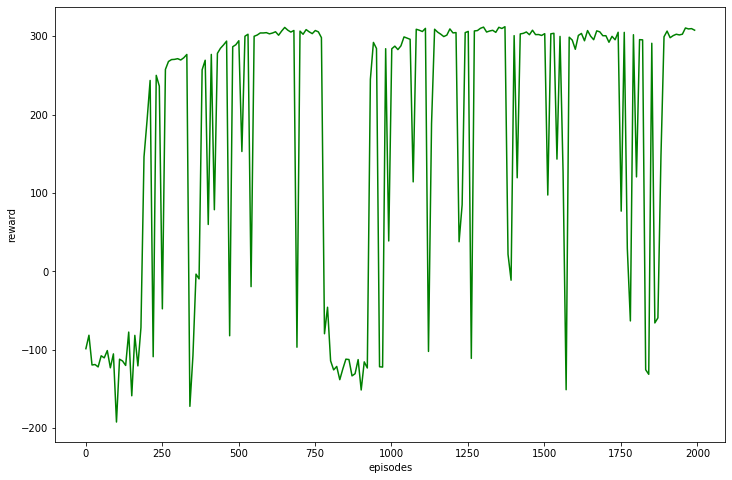

In [70]:
x = np.arange(1,EPISODES+1)[::10]
y = reward[::10]
plt.figure(figsize=(12,8))
plt.plot(x,y, color = "green")
plt.xlabel('episodes')
plt.ylabel('reward')

Видно, что примерно за 600 эпизодов агент обучился

Text(0, 0.5, 'reward')

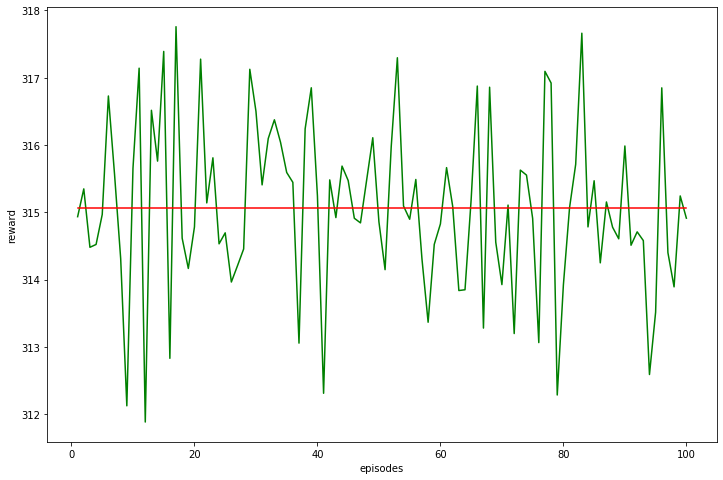

In [71]:
x = np.arange(1,101)
y = reward_test
plt.figure(figsize=(12,8))
plt.plot(x,y, color = "green")
plt.plot(x, average_reward*np.ones(100), color= "red")
plt.xlabel('episodes')
plt.ylabel('reward')

Красной линией обозначен средний ревард за 100 испытаний

Заметим, что reward за 100 испытаний ни разу не упал ниже 311 и тем более не стал отрицательным. Видно, что отклонение небольшое. Это хорошо)

In [72]:
print("Среднеквадратичное отклонение = ", np.std(reward_test))

Среднеквадратичное отклонение =  1.2629194360001925
